In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 18.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 23.3 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16444 sha256=2b83c501feb81cdbfce3877c447bebbcca0ff86591268738f800045a50864d94
  Stored in directory: /root/.cache/pip/wheels/29/16/24/752e89d88d333af39a288421e64d613b5f652918e39ef1f8e3
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60962 sha256=80f763b51fea82fcd964b8bdc787b6011f28ca4582fe0c1fb19e16ac09701c32
  Stored in directory: /root/.cache/pip/w

# Download Full Dataset

Market-1501 dataset :
https://www.kaggle.com/pengcw1/market-1501

In [2]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset

Cloning into 'Person-Re-Id-Dataset'...
remote: Enumerating objects: 12942, done.
remote: Counting objects: 100% (12942/12942), done.
remote: Compressing objects: 100% (12942/12942), done.
remote: Total 12942 (delta 0), reused 12942 (delta 0), pack-reused 0
Receiving objects: 100% (12942/12942), 27.68 MiB | 19.33 MiB/s, done.
Updating files: 100% (12939/12939), done.


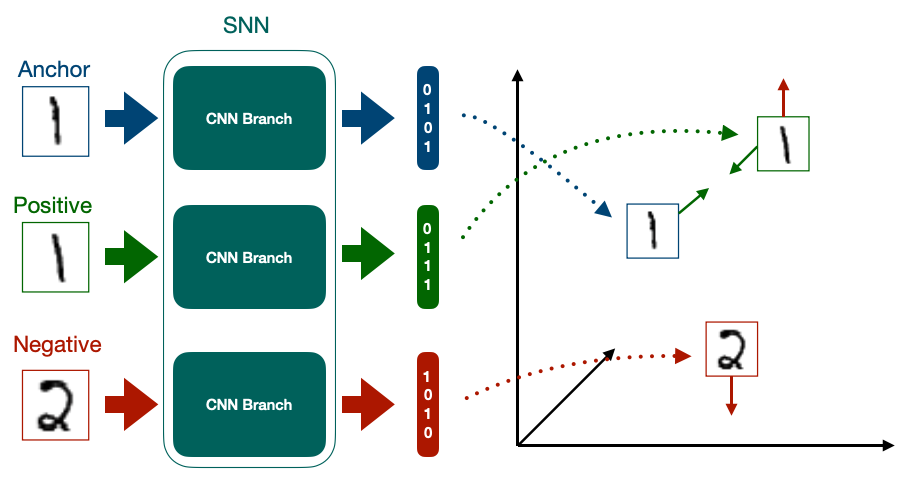

# Imports

In [3]:
import sys 
sys.path.append('/content/Person-Re-Id-Dataset')

In [4]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import torch 
import timm

import torch.nn.functional as F 
from torch import nn 
from torch.utils.data import Dataset, DataLoader 

from skimage import io
from sklearn.model_selection import train_test_split 

from tqdm import tqdm 

# Configurations

In [5]:
data_dir = '/content/Person-Re-Id-Dataset/train/'
csv_file = '/content/Person-Re-Id-Dataset/train.csv'
batch_size = 32
lr = 0.001
epochs = 15
device = 'cuda'

In [6]:
df = pd.read_csv(csv_file)
df.head()

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [7]:
row = df.iloc[15]

a_img = io.imread(data_dir + row.Anchor)
p_img = io.imread(data_dir + row.Positive)
n_img = io.imread(data_dir + row.Negative)

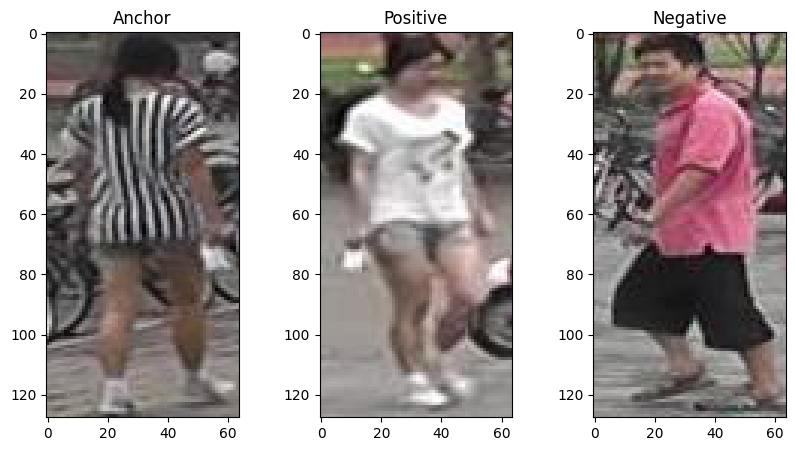

In [8]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize =(10, 5))

ax1.set_title("Anchor")
ax1.imshow(a_img)

ax2.set_title("Positive")
ax2.imshow(p_img)

ax3.set_title("Negative")
ax3.imshow(n_img)

In [9]:
train_df, valid_df = train_test_split(df, test_size = 0.20, random_state = 42)

# Create APN Dataset 

In [10]:
class APN_Dataset(Dataset):
  def __init__(self, df):
    self.df = df

  def __len__(self):
    return len(self.df)
  
  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    a_img = io.imread(data_dir + row.Anchor)
    p_img = io.imread(data_dir + row.Positive)
    n_img = io.imread(data_dir + row.Negative)

    a_img = torch.from_numpy(a_img).permute(2, 0,1) /255.0
    p_img = torch.from_numpy(p_img).permute(2, 0,1) /255.0
    n_img = torch.from_numpy(n_img).permute(2, 0,1) /255.0

    return a_img, p_img, n_img

In [11]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)

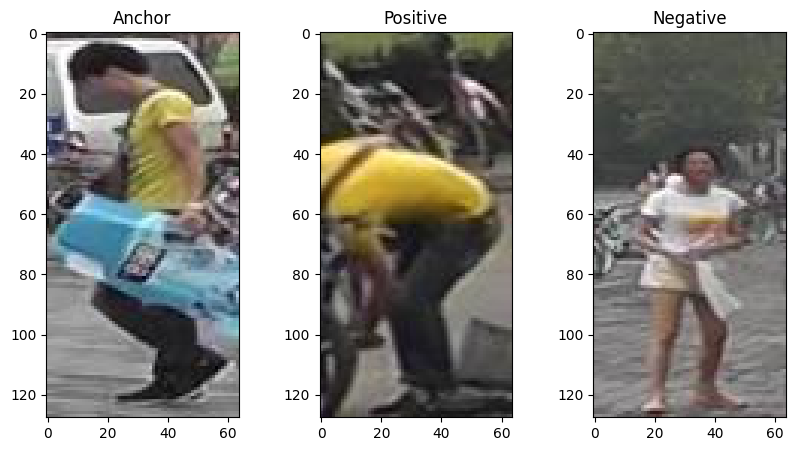

In [12]:
idx = 40
A,P,N = trainset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

# Load Dataset into Batches

In [13]:
trainloader = DataLoader(trainset, batch_size = batch_size, shuffle = True)
validloader = DataLoader(validset, batch_size = batch_size)

In [14]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 100
No. of batches in validloader : 25


In [15]:
for A, P, N in trainloader:
  break;
print(f"One image batch shape : {A.shape}")

One image batch shape : torch.Size([32, 3, 128, 64])


# Create Model 

In [16]:
class APN_Model(nn.Module):

  def __init__(self, emb_size = 512):
    super(APN_Model, self).__init__()
    self.efficientnet = timm.create_model('efficientnet_b0', pretrained = True)
    self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features = emb_size)

  def forward(self, images):
    embeddings = self.efficientnet(images)
    return embeddings

In [17]:
model = APN_Model()
model.to(device);

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_ra-3dd342df.pth


# Create Train and Eval function

In [18]:
def train_fn(model, dataloader, optimizer, criterion):
  model.train()
  total_loss = 0.0

  for A, P, N in tqdm(dataloader):

    A, P, N = A.to(device), P.to(device), N.to(device)

    A_embs = model(A)
    P_embs = model(P)
    N_embs = model(N)

    loss = criterion(A_embs, P_embs, N_embs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss/len(dataloader)

In [19]:
def eval_fn(model, dataloader, criterion):
  model.eval()
  total_loss = 0.0
  with torch.no_grad():
    for A, P, N in tqdm(dataloader):

      A, P, N = A.to(device), P.to(device), N.to(device)

      A_embs = model(A)
      P_embs = model(P)
      N_embs = model(N)

      loss = criterion(A_embs, P_embs, N_embs)

      total_loss += loss.item()

    return total_loss/len(dataloader)

In [20]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

# Create Training Loop

In [21]:
best_valid_loss = np.Inf

for i in range(epochs):
  train_loss = train_fn(model,trainloader,optimizer,criterion)
  valid_loss = eval_fn(model,validloader,criterion)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    best_valid_loss = valid_loss
    print("SAVED_WEIGHTS_SUCCESS")
  
  print(f"epochs : {i+1} train_loss : {train_loss} valid_loss : {valid_loss}")

100%|██████████| 25/25 [00:02<00:00,  9.62it/s]


SAVED_WEIGHTS_SUCCESS
epochs : 1 train_loss : 0.6434672725200653 valid_loss : 0.46547255396842957


100%|██████████| 25/25 [00:03<00:00,  6.61it/s]


SAVED_WEIGHTS_SUCCESS
epochs : 2 train_loss : 0.3166275730729103 valid_loss : 0.39386037826538084


100%|██████████| 25/25 [00:02<00:00,  8.93it/s]


SAVED_WEIGHTS_SUCCESS
epochs : 3 train_loss : 0.21418143987655638 valid_loss : 0.2443033593893051


100%|██████████| 25/25 [00:02<00:00,  8.39it/s]


SAVED_WEIGHTS_SUCCESS
epochs : 4 train_loss : 0.11206564426422119 valid_loss : 0.2146911197900772


100%|██████████| 25/25 [00:02<00:00, 10.05it/s]


SAVED_WEIGHTS_SUCCESS
epochs : 5 train_loss : 0.07821841433644294 valid_loss : 0.20433390140533447


100%|██████████| 25/25 [00:02<00:00,  9.84it/s]


SAVED_WEIGHTS_SUCCESS
epochs : 6 train_loss : 0.06989178195595741 valid_loss : 0.19006046414375305


100%|██████████| 25/25 [00:02<00:00,  9.25it/s]


epochs : 7 train_loss : 0.07190604522824287 valid_loss : 0.2339959102869034


100%|██████████| 25/25 [00:03<00:00,  8.10it/s]


epochs : 8 train_loss : 0.08057932183146477 valid_loss : 0.27084653317928314


100%|██████████| 25/25 [00:04<00:00,  5.09it/s]


SAVED_WEIGHTS_SUCCESS
epochs : 9 train_loss : 0.07250608891248703 valid_loss : 0.18459320813417435


100%|██████████| 25/25 [00:02<00:00, 10.21it/s]


SAVED_WEIGHTS_SUCCESS
epochs : 10 train_loss : 0.04778358280658722 valid_loss : 0.1494312196969986


100%|██████████| 25/25 [00:02<00:00,  9.99it/s]


epochs : 11 train_loss : 0.03840088851749897 valid_loss : 0.20199390411376952


100%|██████████| 25/25 [00:02<00:00,  9.88it/s]


epochs : 12 train_loss : 0.03713032141327858 valid_loss : 0.15036751985549926


100%|██████████| 25/25 [00:02<00:00,  8.56it/s]


epochs : 13 train_loss : 0.031995969712734225 valid_loss : 0.17855943918228148


100%|██████████| 25/25 [00:02<00:00,  9.55it/s]


epochs : 14 train_loss : 0.046408472061157224 valid_loss : 0.21402187943458556


100%|██████████| 25/25 [00:02<00:00,  9.90it/s]

epochs : 15 train_loss : 0.06576799035072327 valid_loss : 0.21051528334617614


# Get Anchor Embeddings

In [41]:
def get_encoding_csv(model, anc_img_names):
  anc_img_names_arr = np.array(anc_img_names)
  encodings = []

  model.eval()
  with torch.no_grad():
    for i in tqdm(anc_img_names_arr):
      A = io.imread(data_dir + i)
      A = torch.from_numpy(A).permute(2,0,1)/255.0
      A = A.to(device)
      A_enc = model(A.unsqueeze(0)) #(c, h,w -->(1, c, h, w)
      encodings.append(A_enc.squeeze().cpu().detach().numpy())
    
    encodings = np.array(encodings)
    encodings = pd.DataFrame(encodings)
    #anc_img_names =np.array(anc_img_names)
    #anc_img_names = pd.DataFrame(anc_img_names)
    df_enc = pd.concat([anc_img_names, encodings], axis = 1)
  return df_enc


In [42]:
model.load_state_dict(torch.load('best_model.pt'))
df_enc = get_encoding_csv(model, df['Anchor'])

100%|██████████| 4000/4000 [00:45<00:00, 87.62it/s]


In [43]:
df_enc.to_csv('database.csv', index= False)
#df_enc.rename(columns={ df.columns[0]: "Anchor" })
#df_enc.rename(columns={ df.columns[1]: "Anchor" }, inplace = True)
#df_enc.rename(columns={'0': 'Anchor'})
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,1420_c5s3_052165_01.jpg,0.198258,-0.962541,0.189569,0.020117,-0.512859,-0.453501,-0.277941,0.028312,-1.177437,...,0.338679,0.266775,0.131610,1.998632,0.624466,-1.151414,0.555852,0.331313,0.220618,0.213328
1,1420_c3s3_061978_03.jpg,0.361307,-0.113593,0.317410,0.007504,-0.888309,-0.628913,-0.614648,0.613824,-0.317266,...,-0.181317,-0.335660,0.316643,1.490904,0.139778,-0.972115,0.462453,0.134294,0.482134,0.205505
2,1420_c5s3_062565_05.jpg,0.216511,-0.364468,0.215064,-0.189408,-0.558477,-0.425268,-0.520441,0.406736,-0.383574,...,0.075985,-0.237704,0.220434,1.588662,0.135489,-0.903899,0.542408,0.325256,0.175207,0.282194
3,1420_c6s3_085592_04.jpg,0.215140,-0.858094,0.219532,0.047991,-0.701776,-0.459434,-0.502459,0.169067,-0.794522,...,-0.014385,-0.071295,0.231787,2.072711,0.454077,-0.973164,0.442796,0.460745,0.331195,0.267798
4,0663_c5s3_085987_03.jpg,0.275373,0.456187,-0.111928,0.729141,0.013673,-0.590729,0.651592,-0.986922,-0.507432,...,0.815463,0.277043,-0.023595,-0.189518,0.440854,-0.168336,-0.193108,-0.409178,0.282008,0.087552


# Inference

In [44]:
def euclidean_dist(img_enc, anc_enc_arr):
  dist = np.sqrt(np.dot(img_enc-anc_enc_arr, (img_enc - anc_enc_arr).T))
  return dist

In [45]:
idx = 0
img_name = df_enc['Anchor'].iloc[idx]
img_path = data_dir + img_name

img = io.imread(img_path)
img = torch.from_numpy(img).permute(2,0,1)/255.0

model.eval()
with torch.no_grad():
  img = img.to(device)
  img_enc = model(img.unsqueeze(0))
  img_enc = img_enc.detach().cpu().numpy()

In [46]:
anc_enc_arr = df_enc.iloc[:, 1:].to_numpy()
anc_img_names = df_enc['Anchor']

In [47]:
distance = []

for i in range(anc_enc_arr.shape[0]):
  dist = euclidean_dist(img_enc, anc_enc_arr[i : i+1, :])
  distance = np.append(distance, dist)

In [48]:
closest_idx = np.argsort(distance)

/usr/local/lib/python3.9/dist-packages/networkx/drawing/layout.py:726: RuntimeWarning: divide by zero encountered in true_divide
  costargs = (np, 1 / (dist_mtx + np.eye(dist_mtx.shape[0]) * 1e-3), meanwt, dim)


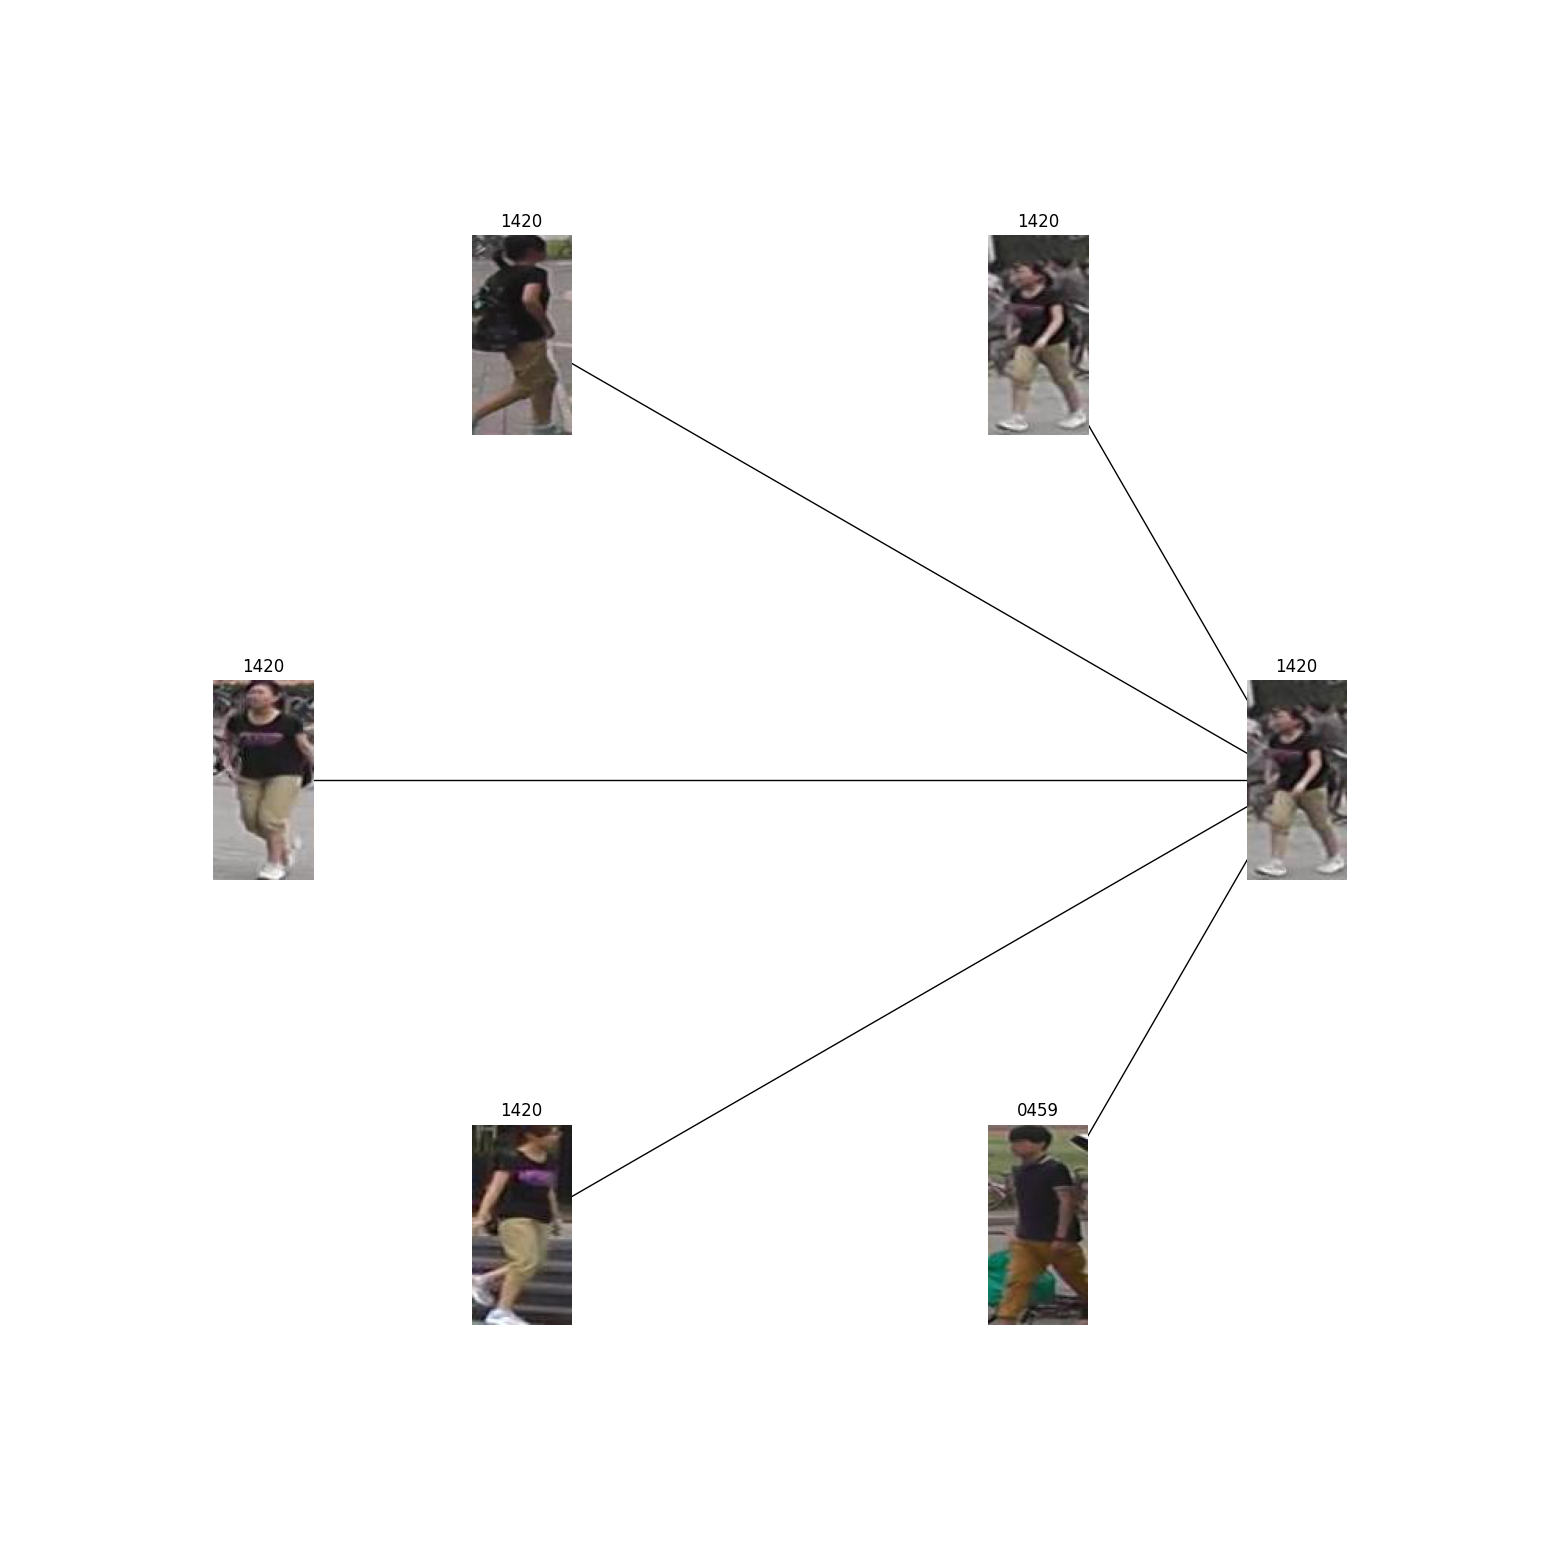

In [50]:
from utils import plot_closest_imgs

plot_closest_imgs(anc_img_names, data_dir, img, img_path, closest_idx, distance, no_of_closest = 5);